## Prep to run this notebook:
- python scripts/run_vk_ref_geuvadis.py
- python scripts/run_vk_count_geuvadis.py
- python scripts/run_vk_count_geuvadis_wxs.py

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import anndata as ad
import scanpy as sc

import varseek as vk
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
data_dir = os.path.join(RLSRWP_2025_dir, "data")

In [3]:
sequencing_data_out_base = os.path.join(data_dir, "geuvadis_data_base")
geuvadis_reference_files_dir = os.path.join(data_dir, "reference", "geuvadis")
variants_transcriptome_df_path = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet")
reference_genome_t2g = os.path.join(data_dir, "reference", "ensembl_grch37_release113", "t2g.txt")

geuvadis_genotype_true_adata = os.path.join(geuvadis_reference_files_dir, "genotypes_adata_true.h5ad")
adata_combined_path_reference_genome = os.path.join(sequencing_data_out_base, "adata_reference_genome_combined.h5ad")
adata_combined_path_vcrs_final = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w37_k41.h5ad")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
t2g_file = os.path.join(reference_dir, "ensembl_grch37_release113", "t2g.txt")

w_and_k_list_of_dicts = [
    {"w": 27, "k": 31},
    {"w": 37, "k": 41},
    {"w": 47, "k": 51},
]

min_counts = 2
min_samples_per_variant = 3
n_top_variants = 2000
gene_set_to_exclude = {'ENSG00000111640', 'ENSG00000242580', 'ENSG00000243466', 'ENST00000603632', 'ENST00000605760'}  # None, or a set of gene names to exclude from the analysis (in ENSGs)

out_dir = os.path.join(data_dir, f"geuvadis_analysis_total")

In [4]:
if not os.path.isfile(adata_combined_path_reference_genome):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_reference_genome"], output_file_name=adata_combined_path_reference_genome)
if not os.path.isfile(geuvadis_genotype_true_adata):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_genotype"], output_file_name=geuvadis_genotype_true_adata)
if not os.path.isfile(adata_combined_path_vcrs_final):
    vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w37_k41"], output_file_name=adata_combined_path_vcrs_final)

adata_reference = ad.read_h5ad(adata_combined_path_reference_genome)
adata_genotype = ad.read_h5ad(geuvadis_genotype_true_adata)
adata_vcrs = ad.read_h5ad(adata_combined_path_vcrs_final)

os.makedirs(out_dir, exist_ok=True)

In [5]:
adata_vcrs

AnnData object with n_obs × n_vars = 660 × 178549
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'sample_title', 'Sex', 'Biosample ID', 'Population name', 'Superpopulation name'

In [6]:
adata_reference

AnnData object with n_obs × n_vars = 660 × 57905
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'sample_title', 'Sex', 'Biosample ID', 'Population name', 'Superpopulation name'

## Which samples were excluded due to faulty FASTQs?

In [7]:
# 1. Get all child directory names
all_dirs = [
    name for name in os.listdir(sequencing_data_out_base)
    if os.path.isdir(os.path.join(sequencing_data_out_base, name)) and name.startswith("E_GEUV_1")
]

# 2. Get the list of experiment aliases from AnnData
aliases_in_adata = set(adata_vcrs.obs['experiment_alias_underscores_only'].unique())

# 3. Get directories not listed in adata
unmatched_dirs = [d for d in all_dirs if d not in aliases_in_adata]
unmatched_dirs

['E_GEUV_1_NA20527_1_M_111124_6',
 'E_GEUV_1_NA19114_1_M_120209_8',
 'E_GEUV_1_NA11992_1_M_120209_6',
 'E_GEUV_1_HG00117_1_M_120209_1',
 'E_GEUV_1_NA07346_1_M_120209_4',
 'E_GEUV_1_HG00237_4_M_120208_1',
 'E_GEUV_1_NA12156_1_M_120209_7']

In [65]:
print(adata_vcrs.obs['Superpopulation name'].value_counts())
adata_vcrs.obs['Superpopulation name'] = adata_vcrs.obs['Superpopulation name'].replace(
    'European Ancestry,West Eurasia (SGDP)', 'European Ancestry'
)

Superpopulation name
European Ancestry                        494
African Ancestry                         162
European Ancestry,West Eurasia (SGDP)      4
Name: count, dtype: int64


## PP

In [8]:
if not os.path.isfile(variants_transcriptome_df_path):
    vk.utils.download_box_url(box_links_dict["geuvadis_variants"], output_file_name=variants_transcriptome_df_path)

variants_transcriptome_df = pd.read_parquet(variants_transcriptome_df_path)
variants_transcriptome_df['variant_header_cdna'] = variants_transcriptome_df['transcript_ID'] + ":" + variants_transcriptome_df['variant_cdna']
adata_genotype.var = adata_genotype.var.merge(variants_transcriptome_df[["variant_header", "variant_header_cdna"]], how="left", on="variant_header")
adata_genotype.var.rename(columns={"variant_header": "variant_header_cds", "variant_header_cdna": "variant_header"}, inplace=True)
adata_genotype.var.index = adata_genotype.var.index.astype(str)  # otherwise I get AssertionError: Don’t call _normalize_index with non-categorical/string names
adata_genotype.obs.index = adata_genotype.obs.index.astype(str)
adata_genotype.obs['sample_title'] = adata_genotype.obs.index.astype(str).str.slice(2)

adata_reference.var['gene'] = adata_reference.var.index.str.split(".").str[0]
t2g_dict = vk.utils.make_t2g_dict(t2g_file, strip_versions=True)

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2276: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


In [ ]:
adata_vcrs = adata_vcrs[:, ~adata_vcrs.var_names.str.contains(";")]   # Remove columns (variants) with semicolon in name

if "transcript_ID" not in adata_vcrs.var.columns:
    adata_vcrs.var['transcript_ID'] = [idx.split(':')[0] for idx in adata_vcrs.var_names]

if "gene_id" not in adata_vcrs.var.columns:
    adata_vcrs.var["gene_id"] = adata_vcrs.var["transcript_ID"].map(t2g_dict).fillna(adata_vcrs.var["transcript_ID"])

if min_counts is not None:
    adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)

if "variant_count" not in adata_vcrs.var.columns:
    adata_vcrs.var["variant_count"] = adata_vcrs.X.sum(axis=0).A1 if hasattr(adata_vcrs.X, "A1") else np.asarray(adata_vcrs.X.sum(axis=0)).flatten()

### Ensure adata_genotype is aligned with adata_vcrs

In [ ]:
# 1. Get variant headers from genotype
variant_headers = adata_genotype.var['variant_header'].values
header_set = set(variant_headers)

# 2. Ensure all vcrs variants are present in genotype
missing = [v for v in adata_vcrs.var.index if v not in header_set]
if missing:
    print(f"{len(missing)} variants in adata_vcrs.var.index were not found in adata_genotype.var['variant_header'] and will be removed.")
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var.index.isin(missing)].copy()

# 3. Find indices in the correct order
variant_to_col = {v: i for i, v in enumerate(variant_headers)}
cols_to_keep = [variant_to_col[v] for v in adata_vcrs.var.index]

# 4. Subset adata_genotype to match the order
adata_genotype = adata_genotype[:, cols_to_keep].copy()

if "transcript_ID" not in adata_genotype.var.columns:
    adata_genotype.var['transcript_ID'] = [header.split(':')[0] for header in adata_genotype.var['variant_header']]

if "gene_id" not in adata_genotype.var.columns:
    adata_genotype.var["gene_id"] = adata_genotype.var["transcript_ID"].map(t2g_dict).fillna(adata_genotype.var["transcript_ID"])

11 variants in adata_vcrs.var.index were not found in adata_genotype.var['variant_header'] and will be removed.


In [ ]:
if gene_set_to_exclude is not None:
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['transcript_ID'].isin(gene_set_to_exclude).values]
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['gene_id'].isin(gene_set_to_exclude).values]
    adata_genotype = adata_genotype[:, ~adata_genotype.var['transcript_ID'].isin(gene_set_to_exclude).values]
    adata_genotype = adata_genotype[:, ~adata_genotype.var['gene_id'].isin(gene_set_to_exclude).values]

## Each sample is a "cell", and each variant is a "gene"

In [46]:
sc.pp.filter_genes(adata_vcrs, min_cells=min_samples_per_variant)

In [57]:
sc.pp.log1p(adata_vcrs)

In [58]:
sc.pp.highly_variable_genes(adata_vcrs, n_top_genes=n_top_variants, batch_key="Population name")

In [62]:
adata_vcrs.obs.head()

,experiment_alias_underscores_only,experiment_accession,library_strategy,sample_title,Sex,Biosample ID,Population name,Superpopulation name
0,E_GEUV_1_HG00097_7_M_120219_2,ERX162845,RNA-Seq,HG00097,female,SAME123267,British,European Ancestry
1,E_GEUV_1_NA19160_3_M_120202_3,ERX163146,RNA-Seq,NA19160,male,SAME123758,Yoruba,African Ancestry
2,E_GEUV_1_NA11993_2_M_111216_4,ERX162995,RNA-Seq,NA11993,female,SAME123965,CEPH,European Ancestry
3,E_GEUV_1_NA20520_3_M_120202_2,ERX163113,RNA-Seq,NA20520,male,SAME124019,Toscani,European Ancestry
4,E_GEUV_1_HG00306_1_M_111124_1,ERX162927,RNA-Seq,HG00306,female,SAME124159,Finnish,European Ancestry


In [59]:
do_scaling = True

if do_scaling:
    adata_vcrs.raw = adata_vcrs.copy()
    sc.pp.scale(adata_vcrs, max_value=None)

In [60]:
sc.tl.pca(adata_vcrs)

## Let's hope for some juicy clusters!

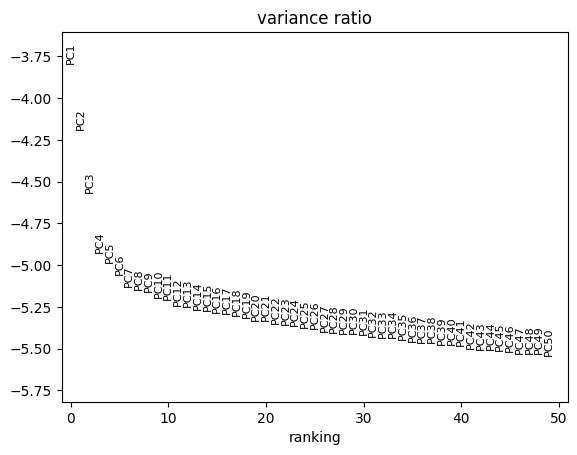

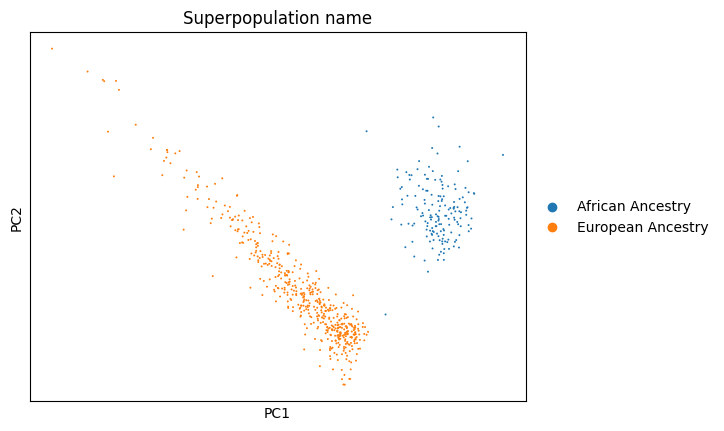

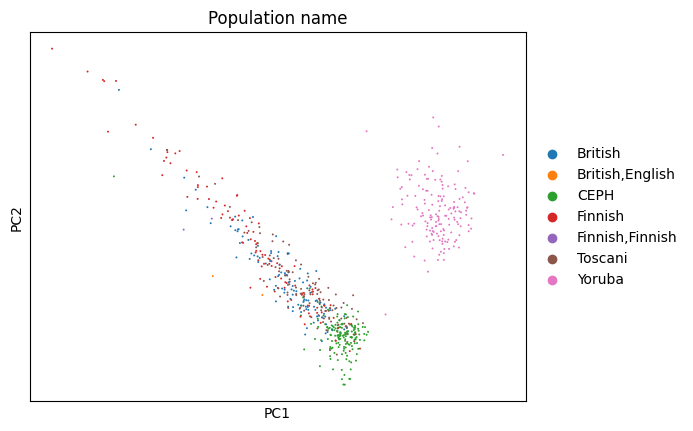

In [73]:
sc.pl.pca_variance_ratio(adata_vcrs, n_pcs=50, log=True)

sc.pl.pca(
    adata_vcrs,
    color=["Superpopulation name"],
    dimensions=[(0, 1)],
    size=8,
)

sc.pl.pca(
    adata_vcrs,
    color=["Population name"],
    dimensions=[(0, 1)],
    ncols=2,
    size=8,
)

In [ ]:
if do_scaling:
    adata_vcrs.raw.to_adata()